<a href="https://colab.research.google.com/github/mlellouch/reshape/blob/main/reshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is reshape order important?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Setting a general training function

In [2]:
def single_epoch_train(model: nn.Module, trainloader, optimizer, criterion):
  """
  Does a single train epoch, and returns the average loss
  """
  train_loss = 0.0
  for data in trainloader:
    inputs, labels = data
    inputs = inputs.to(device=device)
    labels = labels.to(device=device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  return train_loss / len(trainloader)

def test_model(model: nn.Module, testloader):
  """
  Tests the accuracy of the model
  """
  total = 0.0
  correct = 0.0
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device=device)
        labels = labels.to(device=device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  return correct / total


def train(epochs: int, batch_size: int, model: nn.Module):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  model = model.to(device=device)
  train_losses = []
  test_accuracy = []
  for epoch in tqdm(range(epochs), desc='training model'):
    train_loss = single_epoch_train(model=model, trainloader=trainloader, optimizer=optimizer, criterion=criterion)
    accuracy = test_model(model=model, testloader=testloader)

    train_losses.append(train_loss)
    test_accuracy.append(accuracy)

  # show the results
  plt.plot(train_losses)
  plt.title('average train loss per epoch')
  plt.show()
  plt.plot(test_accuracy)
  plt.title('test set accuracy per epoch')
  plt.show()

# Test With Normal Network

In [3]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc = nn.Linear(in_features=16 * 5 * 5, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch, this is how the final reshape should be
        x = self.fc(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


training model: 100%|██████████| 20/20 [19:28<00:00, 58.45s/it]


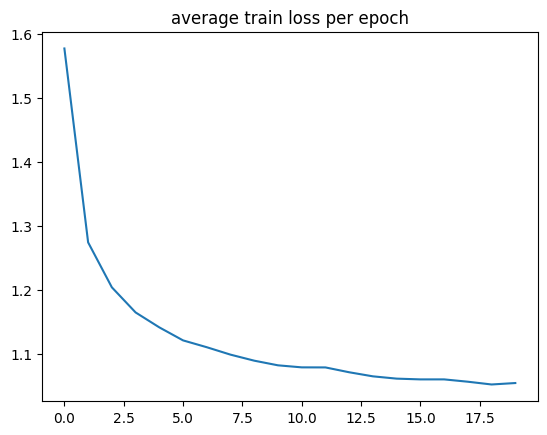

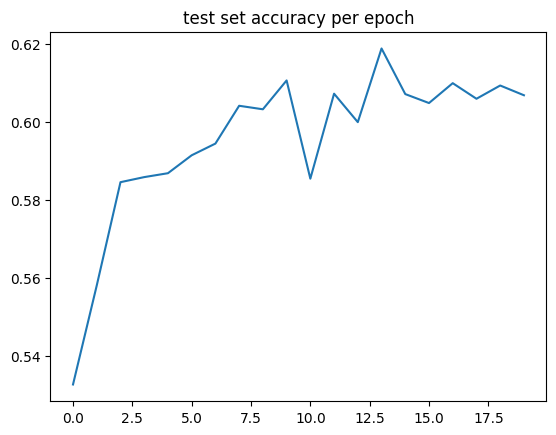

In [5]:
train(epochs=20, batch_size=5, model=LeNet())

# Now For the Bad Case

In [6]:
def bad_flatten(tensor: torch.Tensor):
  tensor = tensor.permute([3, 1, 2, 0]) # we're changing the x axis with the "image" axis
  return torch.flatten(tensor, 1)

class BadNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc = nn.Linear(in_features=16 * 5 * 5, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = bad_flatten(x) 
        x = self.fc(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


training model: 100%|██████████| 20/20 [20:55<00:00, 62.78s/it]


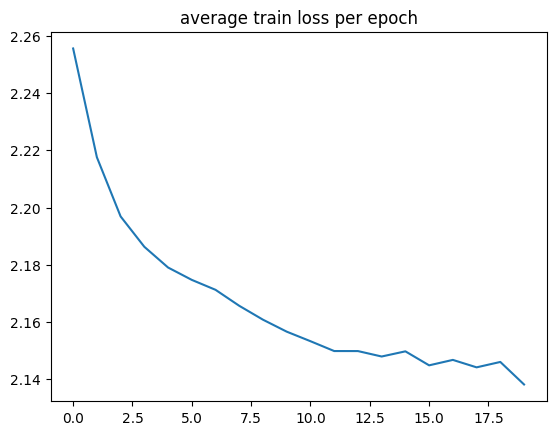

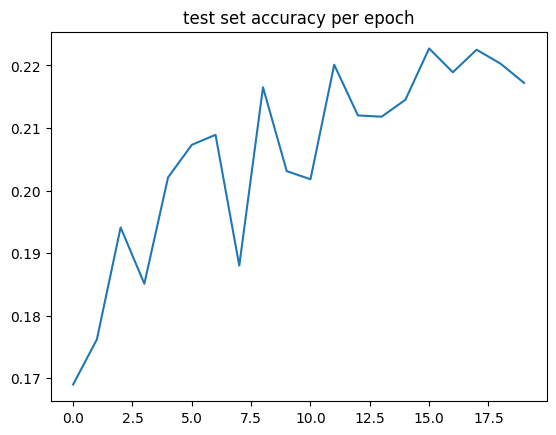

In [7]:
train(epochs=20, batch_size=5, model=BadNet())